In [29]:
import torch
from torch import nn
import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [72]:
functions = [
    lambda x,y: torch.max(x,y),
    lambda x,y: x * torch.exp(-y / 10),
    lambda x,y: x + y,
    lambda x,y: x - y * 2,
    lambda x,y: torch.log(1 + x) + 2*y
]
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.__getitem__

In [73]:
config = dotdict({
    "d_model": 1024,
    "epochs": 2000,
    "batch_size": 64,
    "lr": 0.0005,
    "wd": 0.0001,
    "n_layers": 1,
    "max_range": 100,
    "train_frac": 0.7,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
})
X = torch.cartesian_prod(torch.arange(config.max_range), torch.arange(config.max_range))
X_extrap = torch.cartesian_prod(torch.arange(config.max_range, 2*config.max_range), torch.arange(config.max_range, 2*config.max_range))
y = torch.hstack([f(x,y) for x,y in X for f in functions]).view(-1, len(functions))
y_extrap = torch.hstack([f(x,y) for x,y in X_extrap for f in functions]).view(-1, len(functions))
scaler = MinMaxScaler((-1, 1))
y = torch.tensor(scaler.fit_transform(y)).float().to(config.device)
y_extrap = torch.tensor(scaler.transform(y_extrap)).float().to(config.device)
validation_mask = torch.rand(len(X)) < config.train_frac

In [74]:
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(2, config.d_model)
        self.lstm = nn.LSTM(config.d_model, config.d_model, config.n_layers, batch_first=True)
        self.readout = nn.Sequential(nn.Linear(config.d_model * 2, config.d_model),
                                      nn.ReLU(),
                                      nn.Linear(config.d_model, len(functions)),
                                      nn.Tanh())

        
    def forward(self, operands):
        output_seq = self.get_embeddings(operands.max()+1)
        embedded_operands = output_seq.squeeze(0)[operands]
        return self.readout(embedded_operands.flatten(1))
    
    def get_embeddings(self, max_range):
        one_embed = self.embedding.weight[[1]]
        inputs = one_embed.unsqueeze(1).expand(-1, max_range, -1)
        output_seq, _ = self.lstm(inputs)
        return output_seq
        

- Embedding for integer 1
- Increment to obtain new integers
- Do addition or some other function on the integers

In [75]:
# training loop
model = Model(config).to(config.device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs, eta_min=1e-7)
pbar = tqdm.trange(config.epochs)
X_train = X[~validation_mask].to(config.device)
X_val = X[validation_mask].to(config.device)
y_train = y[~validation_mask].to(config.device)
y_val = y[validation_mask].to(config.device)


def unscale(x):
    return torch.tensor(scaler.inverse_transform(x.detach().cpu().numpy())).to(config.device)


y_train_unscaled = unscale(y_train)
y_val_unscaled = unscale(y_val)
y_extra_unscaled = unscale(y_extrap)

for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    pred_train = model(X_train)
    train_loss = criterion(pred_train, y_train).sqrt()
    train_loss.backward()
    optimizer.step()
    scheduler.step()
    with torch.no_grad():
        model.eval()
        train_loss = criterion(unscale(pred_train), y_train_unscaled).sqrt()
        val_loss = criterion(unscale(model(X_val)), y_val_unscaled).sqrt()
        loss_extrap = criterion(unscale(model(X_extrap)), y_extra_unscaled).sqrt()
        pbar.set_description(
            f"Epoch {epoch}: {train_loss.item():.3f}, {val_loss.item():.3f}, {loss_extrap.item():.3f}"
        )

Epoch 1999: 0.221, 0.267, 82.616: 100%|██████████| 2000/2000 [00:52<00:00, 37.93it/s]


0 <lambda>


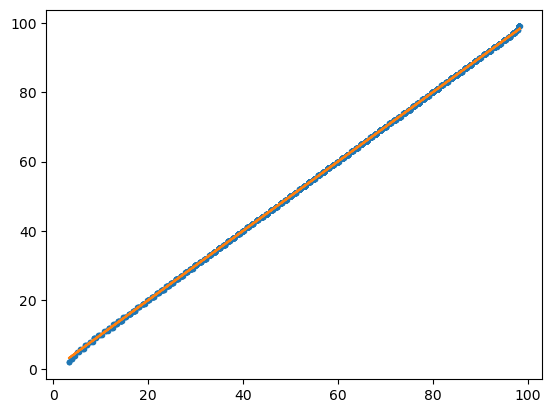

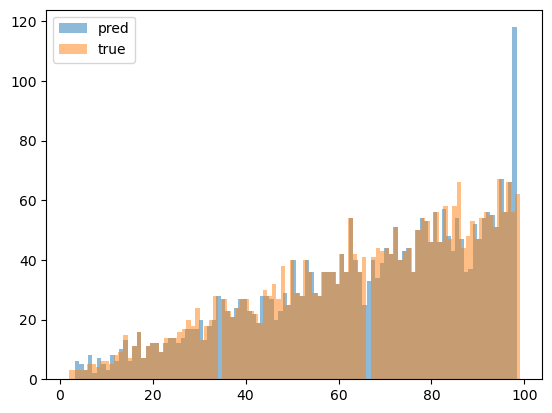

1 <lambda>


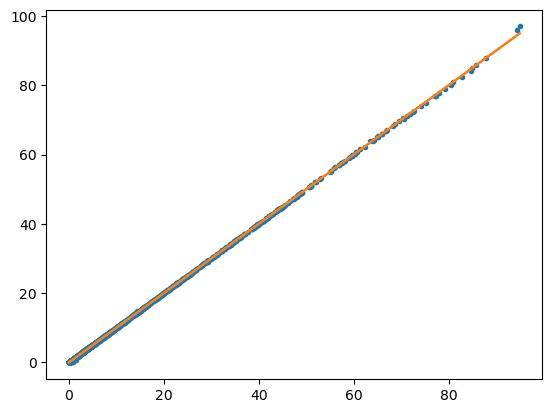

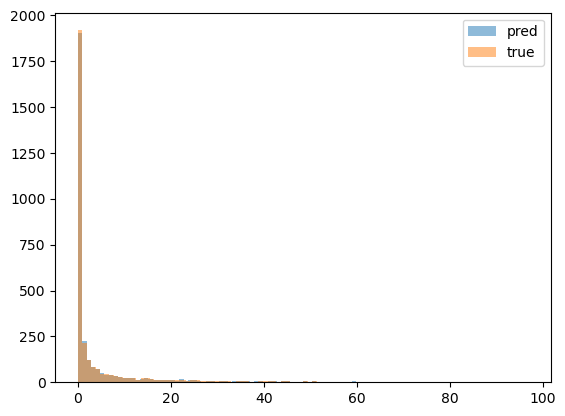

2 <lambda>


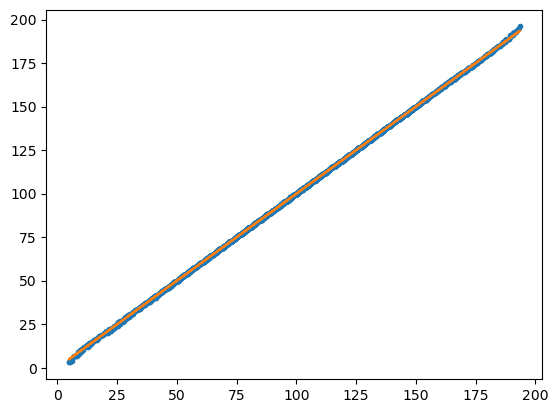

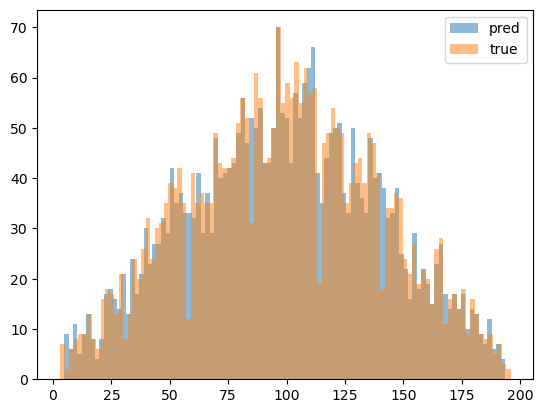

3 <lambda>


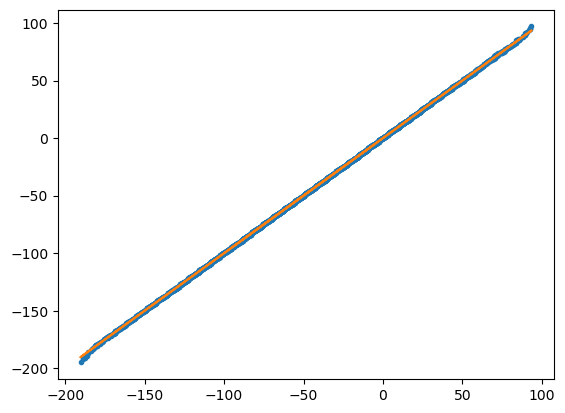

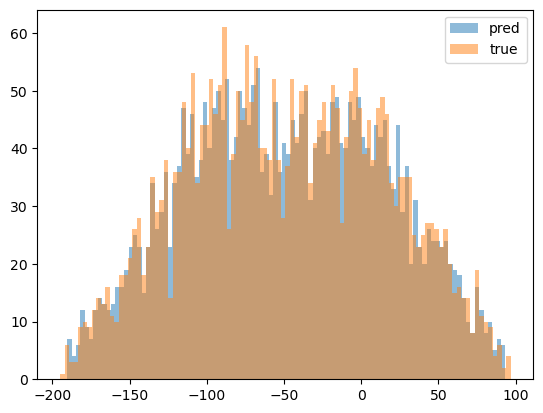

4 <lambda>


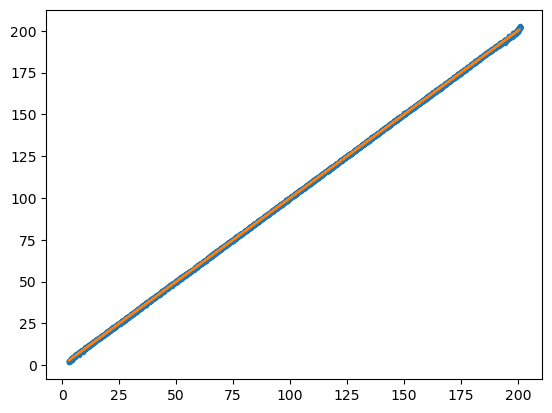

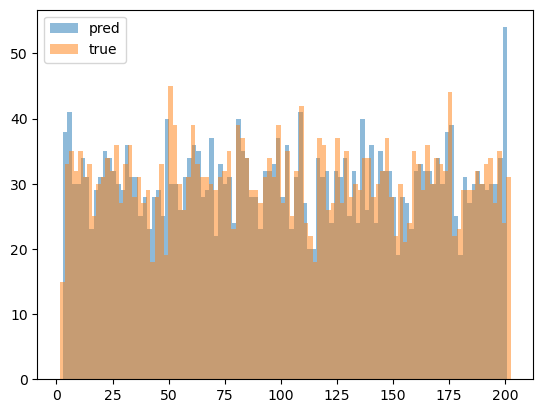

In [76]:
x_range = X_train
y_range = y_train
for i in range(len(functions)):
    print(i, functions[i].__name__)
    plt.plot(unscale(model(x_range))[:,i].detach().cpu().numpy(), unscale(y_range)[:,i].detach().cpu().numpy(), ".")
    plt.plot(unscale(model(x_range))[:,i].detach().cpu().numpy(), unscale(model(x_range))[:,i].detach().cpu().numpy())
    plt.show()
    plt.hist(unscale(model(x_range))[:,i].detach().cpu().numpy(), bins=100, alpha=0.5, label="pred")
    plt.hist(unscale(y_range)[:,i].detach().cpu().numpy(), bins=100, alpha=0.5, label="true")
    plt.legend()
    plt.show()

In [77]:
embeddings = model.get_embeddings(config.max_range).squeeze(0).cpu().detach().numpy()

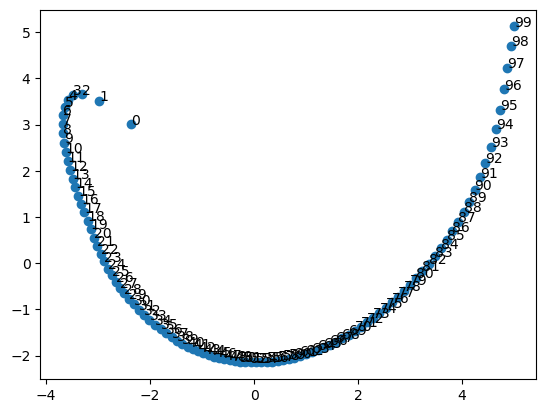

In [78]:
# pca on those embeddings and plot them
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embeddings)
embeddings_pca = pca.transform(embeddings)
plt.scatter(embeddings_pca[:,0], embeddings_pca[:,1])
for i in range(config.max_range):
    plt.annotate(str(i), embeddings_pca[i])
plt.show()